## Goals

### Visualization
1. Plot series over the entire four year timeframe
2. Plot average monthly consumption
3. Plot typical daily consumption by month

### Forecasting 
1. Predict household consumption for a given date and time.

## Get Data

In [545]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly as py
import plotly.graph_objs as go
py.tools.set_credentials_file(username='mkivenson', api_key='Y19BsRhiyhvFyZe72Gzw')

In [555]:
#Import data file
path = 'household_power_consumption.txt'

dtypes = {'Date': str,
          'Time': str,
          'Global_active_power': float,
          'Global_reactive_power': float,
          'Voltage': float,
          'Global_intensity': float,
          'Sub_metering_1': float,
          'Sub_metering_2': float,
          'Sub_metering_3': float}

#drop na values
energy = pd.read_csv(path, sep=';',dtype=dtypes, na_values="?")
energy = energy.dropna()

In [556]:
#Insert additional columns
energy.insert(0, 'Date_Time', pd.to_datetime(energy['Date'] + ' ' + energy['Time'])) #datetime format
energy.insert(2, 'Year',energy['Date_Time'].dt.year) #year
energy.insert(3, 'Month',energy['Date_Time'].dt.month) #month
energy.insert(4, 'Day',energy['Date_Time'].dt.weekday) #weekday_name
energy.insert(5, 'Hour',energy['Date_Time'].dt.hour) #hour

#Exclude other numerical variables (univariate analysis)
energy = energy.iloc[:,0:8]

#Preview data
energy.head()

,Date_Time,Date,Year,Month,Day,Hour,Time,Global_active_power
0,2006-12-16 17:24:00,16/12/2006,2006,12,5,17,17:24:00,4.216
1,2006-12-16 17:25:00,16/12/2006,2006,12,5,17,17:25:00,5.360
2,2006-12-16 17:26:00,16/12/2006,2006,12,5,17,17:26:00,5.374
3,2006-12-16 17:27:00,16/12/2006,2006,12,5,17,17:27:00,5.388
4,2006-12-16 17:28:00,16/12/2006,2006,12,5,17,17:28:00,3.666


## Explore and Visualize Series

### Descriptive Analysis

In [558]:
np.round(energy['Global_active_power'].describe(), 2).apply(lambda x: format(x, 'f'))

count    2049280.000000
mean           1.090000
std            1.060000
min            0.080000
25%            0.310000
50%            0.600000
75%            1.530000
max           11.120000
Name: Global_active_power, dtype: object

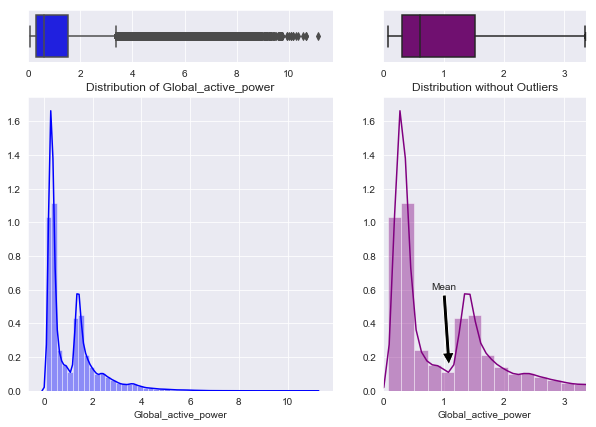

In [559]:
f, axes = plt.subplots(2,2, figsize=(10, 7), sharex=False, gridspec_kw={"height_ratios": (.15, .85),
                                                                       "width_ratios":(.60,.40)})
sns.boxplot(energy["Global_active_power"] , color="blue", ax=axes[0,0])
axes[0,0].set_xlabel('')
axes[0,0].set_xlim(0, None)
sns.distplot(energy["Global_active_power"] , color="blue", ax=axes[1,0])
axes[0,0].set_xlim(0, None)
axes[1,0].set_title('Distribution of Global_active_power')

sns.boxplot(energy["Global_active_power"], color="purple", ax=axes[0,1])
axes[0,1].set_xlabel('')
axes[0,1].set_xlim(0, 3.37)

sns.distplot(energy["Global_active_power"], color="purple", ax=axes[1,1])
axes[1,1].set_title('Distribution without Outliers')
axes[1,1].set_xlim(0, 3.37)
# Annotate
axes[1,1].annotate(
'Mean', xy=(energy["Global_active_power"].mean(), .15), xytext=(.8, .6),
arrowprops=dict(facecolor='black', shrink=0.01))

plt.show()

/Users/MaryAnna/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



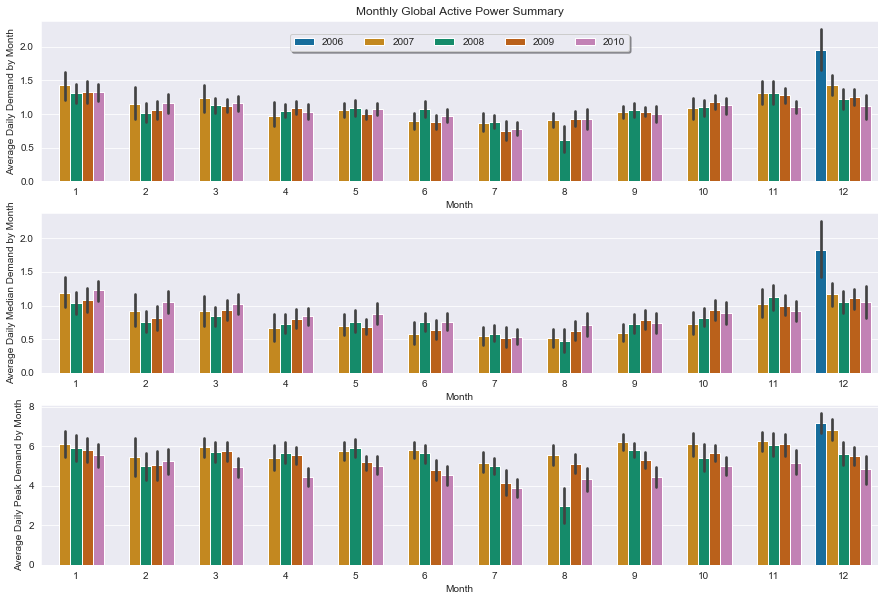

In [560]:
energy_monthly_summary = energy.groupby(by=['Year','Month','Date'],
                                        as_index=False).agg({'Global_active_power':{'mean_active_power': 'mean', 
                                                                                    'median_active_power': 'median', 
                                                                                    'max_active_power': 'max'}})

energy_monthly_summary.head()
sns.set_style("darkgrid")
f, axes = plt.subplots(3, figsize=(15, 10), sharex=False)
mean = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.Global_active_power.mean_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[0])
mean.set_title('Monthly Global Active Power Summary')
mean.set_ylabel('Average Daily Demand by Month')

mean.legend_.remove()
              
median = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.Global_active_power.median_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[1])
median.legend_.remove()
median.set_ylabel('Average Daily Median Demand by Month')

max = sns.barplot(x=energy_monthly_summary.Month,
            y=energy_monthly_summary.Global_active_power.max_active_power,
            hue=energy_monthly_summary.Year,
            palette="colorblind",
            ax=axes[2])
max.set_ylabel('Average Daily Peak Demand by Month')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 3.35), shadow=True, ncol=5)


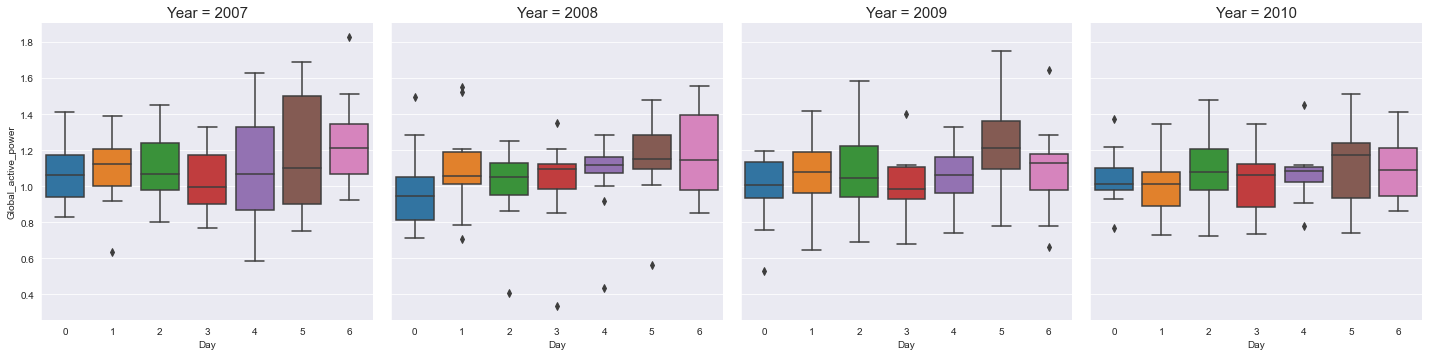

In [561]:
energy_weekday_summary = energy.groupby(by=['Year','Month','Day'], as_index=False)[['Global_active_power']].mean()

day_plot = sns.catplot(x="Day", y="Global_active_power", data=energy_weekday_summary.query("Year != 2006"), 
           kind="box",
           col="Year")
day_plot.set_titles(size = 15)


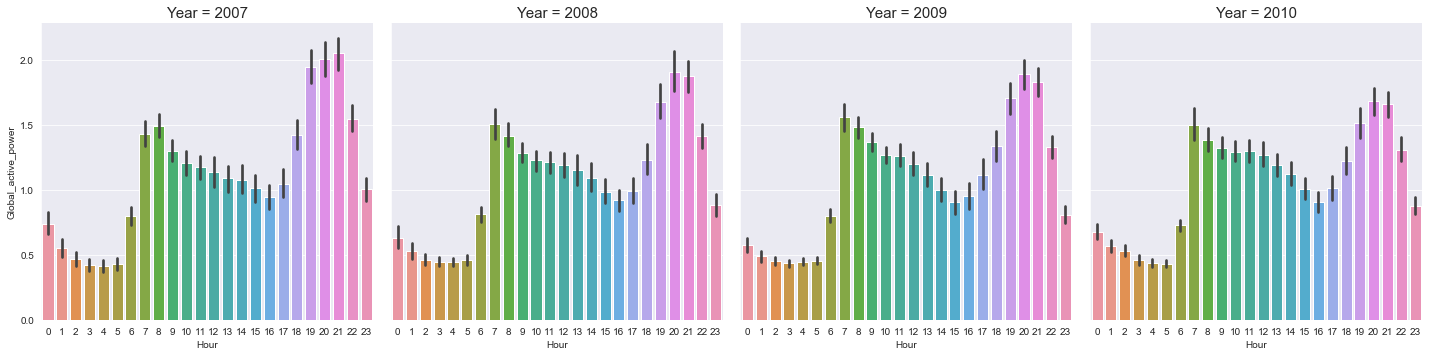

In [562]:
energy_hourly_summary = energy.groupby(by=['Year','Month','Day','Hour'], 
                                       as_index=False)[['Global_active_power']].mean()

hour_plot = sns.catplot(x="Hour", y="Global_active_power", data=energy_hourly_summary.query("Year != 2006"), 
           kind="bar",
           col="Year")
hour_plot.set_titles(size = 15)

### Visualizations

In [564]:
energy.Date = pd.to_datetime(energy['Date'])
energy_daily_summary = energy.groupby('Date', 
                                      as_index=False).agg(
    {'Global_active_power':{'mean_active_power': 'mean',
                            'median_active_power': 'median',
                            'max_active_power': 'max'}})
mean_power = go.Scatter(x=energy_daily_summary.Date,
                        y=energy_daily_summary.Global_active_power.mean_active_power,
                        name='mean_power',
                        line=dict(color='red'))

median_power = go.Scatter(x=energy_daily_summary.Date,
                            y=energy_daily_summary.Global_active_power.median_active_power,
                            name='median_power',
                            line=dict(color='blue'))

max_power = go.Scatter(x=energy_daily_summary.Date,
                       y=energy_daily_summary.Global_active_power.max_active_power,
                       name='max_power',
                       line=dict(color='green'))

updatemenus = list([
    dict(type="buttons",
         active=-1,
         buttons=list([
            dict(label = 'Mean',
                 method = 'update',
                 args = [{'visible': [True, False, False]},
                         {'title': 'Mean Global Active Power'}]),
                         
            dict(label = 'Median',
                 method = 'update',
                 args = [{'visible': [False, True, False]},
                         {'title': 'Median Global Active Power'}]),
                         
            dict(label = 'Maximum',
                 method = 'update',
                 args = [{'visible': [False, False, True]},
                         {'title': 'Maximum Global Active Power'}]),
            dict(label = 'All',
                 method = 'update',
                 args = [{'visible': [True, True, True]},
                         {'title': 'Overview of Global Active Power'}]),              
        ]),
    )
])

data = [mean_power, median_power, max_power]

layout = dict(title='Daily Global Active Power', 
              showlegend=True, 
              updatemenus = updatemenus,
              legend=dict(orientation="h"),
              xaxis = dict(
                  rangeselector=dict(
                      buttons=list([
                          dict(count=1,
                             label='1m',
                             step='month',
                             stepmode='backward'),
                          dict(count=6,
                             label='6m',
                             step='month',
                             stepmode='backward'),
                          dict(count=1,
                            label='1y',
                            step='year',
                            stepmode='todate'),
                          dict(count=2,
                            label='2y',
                            step='year',
                            stepmode='backward'),
                          dict(step='all')
                      ]))))

plot = dict(data=data, layout=layout)
py.plotly.iplot(plot, filename='household_power_consumption')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mkivenson/0 or inside your plot.ly account where it is named 'household_power_consumption'


/Users/MaryAnna/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## Pre-Process Data

In [565]:
energy.dtypes

Date_Time              datetime64[ns]
Date                   datetime64[ns]
Year                            int64
Month                           int64
Day                             int64
Hour                            int64
Time                           object
Global_active_power           float64
dtype: object

In [710]:
from sklearn import preprocessing

#summarize by mean hourly energy
energy_hourly_summary = energy.groupby(
    by=['Year','Month','Day',"Hour"], as_index=False)[['Global_active_power']].mean()

# create the Label Encoder object
le = preprocessing.LabelEncoder()

#encode categorical data
energy_hourly_summary['Year'] = le.fit_transform(energy_hourly_summary['Year'])

energy_hourly_summary.head()

,Year,Month,Day,Hour,Global_active_power
0,0,12,0,0,0.637967
1,0,12,0,1,0.760033
2,0,12,0,2,0.361233
3,0,12,0,3,0.449950
4,0,12,0,4,0.802500


## Time Series Forecasting

### Train-Test Split

#### Partition Series

In [724]:
# Partition Series
from sklearn.model_selection import train_test_split
x = energy_hourly_summary[['Year','Month','Day','Hour']]
y = energy_hourly_summary.Global_active_power
x_train1,x_test1,y_train1,y_test1=train_test_split(x, y, train_size=0.75, test_size = 0.25, random_state=1)

#### Apply Forecasting Methods

In [725]:
# Apply Forecasting Methods
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
model = lm.fit(x_train1, y_train1)
predictions=lm.predict(x_test1)

#### Evaluate Performance

In [ ]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test1, predictions)

plt.plot(y_test1, predictions, 'o', label='data')
plt.plot(y_test1, intercept + slope*y_test1, 'r', label='fitted line')
plt.legend()
plt.annotate(
'y = ' + str(round(slope,2)) + 'x' + ' + ' + str(round(intercept,2)), xy=(3, 1.5), xytext=(3.2, 1.25),
arrowprops=dict(facecolor='black', shrink=0.01))
plt.xlabel('Actual Values')
plt.title('Actual vs Predicted Values')
plt.ylabel('Predicted Values')
plt.show()
print("r-squared: %f" % r_value**2)

In [803]:
train = energy[energy['Year'] < 4] #train set is years 2006 - 2009
test = energy[energy['Year'] == 4] #test set is year 2010

,Date_Time,Date,Year,Month,Day,Hour,Time,Global_active_power
0,2006-12-16 17:24:00,2006-12-16,0,12,5,17,17:24:00,4.216
1,2006-12-16 17:25:00,2006-12-16,0,12,5,17,17:25:00,5.360
2,2006-12-16 17:26:00,2006-12-16,0,12,5,17,17:26:00,5.374
3,2006-12-16 17:27:00,2006-12-16,0,12,5,17,17:27:00,5.388
4,2006-12-16 17:28:00,2006-12-16,0,12,5,17,17:28:00,3.666


In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

mod = SARIMAX(train[['Date_Time','Global_active_power']].set_index('Date_Time').to_numpy())
results = mod.fit()
results.forecast()


In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [816]:
fcast_index = pd.to_datetime(test['Date_Time']).to_numpy()
results.get_forecast(steps=len(test['Date_Time']), index=fcast_index)

/Users/MaryAnna/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:518: ValueWarning:

Because the model data (`endog`, `exog`) were not given as Pandas objects, the prediction output will be Numpy arrays, and the given `index` argument will only be used internally.



Observations: 2049280
Training (Plotted in Blue): 1536960
Testing (Plotted in Orange): 512320


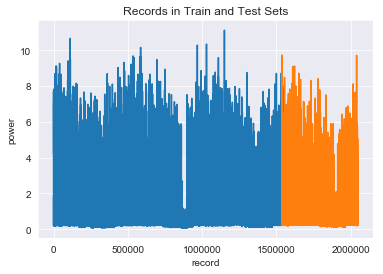

In [623]:
#Time Series Split
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
X = energy[['Year','Month','Day','Hour','Global_active_power']]
train_size = int(len(X) * 0.75)
train1, test1 = X[0:train_size], X[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training (Plotted in Blue): %d' % (len(train)))
print('Testing (Plotted in Orange): %d' % (len(test)))

plt.plot(train1['Global_active_power'])
plt.plot([None for i in train1['Global_active_power']] + [x for x in test1['Global_active_power']])
plt.title('Records in Train and Test Sets')
plt.xlabel('record')
plt.ylabel('power')
plt.show()

## Apply Forecasting Methods

## Evaluate and Compare Performance

## Implement Forecasts